In [1]:
!git clone https://github.com/youyinnn/ai_face_mask_detector.git
%cd ai_face_mask_detector/
!gdown --id 1RHPNOoOVMZrfO77slsyADDTv9398XlWq
!7z x aug_1.7z

Cloning into 'ai_face_mask_detector'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 134 (delta 58), reused 63 (delta 20), pack-reused 0
Receiving objects: 100% (134/134), 58.27 MiB | 13.11 MiB/s, done.
Resolving deltas: 100% (58/58), done.
/content/ai_face_mask_detector
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1RHPNOoOVMZrfO77slsyADDTv9398XlWq
To: /content/ai_face_mask_detector/aug_1.7z
100% 51.4M/51.4M [00:01<00:00, 39.8MB/s]

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for arch

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

import torch.cuda as cuda

from data_process.DatasetHelper import ImageDataset
import torch.nn as nn

# Functional module contains helper functions
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision.transforms as T

from torch.utils.data import random_split, ConcatDataset

tranform_train = T.Compose([
  T.Resize((227,227)),
  # T.ToPILImage(),
  # T.ToTensor(),
  # T.Normalize((133.7900, 122.5296, 116.1627), (78.6071, 76.6452, 77.6168)),
])

# unzip the augmented dataset and load it
data = ImageDataset('aug_1', transform=tranform_train)

l0_data = ImageDataset('aug_1', transform=tranform_train)
l0_data.img_labels = data.img_labels[:1000].copy()

l1_data = ImageDataset('aug_1', transform=tranform_train)
l1_data.img_labels = data.img_labels[1000:2000].copy()

l2_data = ImageDataset('aug_1', transform=tranform_train)
l2_data.img_labels = data.img_labels[2000:3000].copy()

l3_data = ImageDataset('aug_1', transform=tranform_train)
l3_data.img_labels = data.img_labels[3000:4000].copy()

l4_data = ImageDataset('aug_1', transform=tranform_train)
l4_data.img_labels = data.img_labels[4000:5000].copy()

d1, d2, d3, d4, d5, test_data = torch.utils.data.random_split(
    l0_data, [180, 180, 180, 180, 180, 100],
    generator=torch.Generator().manual_seed(789)
)

for data in l1_data, l2_data, l3_data, l4_data:
  new_d1, new_d2, new_d3, new_d4, new_d5, new_test_data = torch.utils.data.random_split(
    data, [180, 180, 180, 180, 180, 100],
    generator=torch.Generator().manual_seed(789)
  )
  d1 = ConcatDataset((d1, new_d1))
  d2 = ConcatDataset((d2, new_d2))
  d3 = ConcatDataset((d3, new_d3))
  d4 = ConcatDataset((d4, new_d4))
  d5 = ConcatDataset((d5, new_d5))
  test_data = ConcatDataset((test_data, new_test_data))

batch_size = 40
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2)

def gen_loader(train_data, val_data):
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=1)
  val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=1)

  return train_loader, val_loader

cross_val_folds = [
  gen_loader(ConcatDataset((d2, d3, d4, d5)), d1),
  gen_loader(ConcatDataset((d3, d4, d5, d1)), d2),
  gen_loader(ConcatDataset((d5, d5, d1, d2)), d3),
  gen_loader(ConcatDataset((d5, d1, d2, d3)), d4),
  gen_loader(ConcatDataset((d1, d2, d3, d4)), d5),
]

label: 0 with 1000 images, named as "cloth_mask"
label: 1 with 1000 images, named as "no_face_mask"
label: 2 with 1000 images, named as "surgical_mask"
label: 3 with 1000 images, named as "n95_mask"
label: 4 with 1000 images, named as "mask_worn_incorrectly"
label: 0 with 1000 images, named as "cloth_mask"
label: 1 with 1000 images, named as "no_face_mask"
label: 2 with 1000 images, named as "surgical_mask"
label: 3 with 1000 images, named as "n95_mask"
label: 4 with 1000 images, named as "mask_worn_incorrectly"
label: 0 with 1000 images, named as "cloth_mask"
label: 1 with 1000 images, named as "no_face_mask"
label: 2 with 1000 images, named as "surgical_mask"
label: 3 with 1000 images, named as "n95_mask"
label: 4 with 1000 images, named as "mask_worn_incorrectly"
label: 0 with 1000 images, named as "cloth_mask"
label: 1 with 1000 images, named as "no_face_mask"
label: 2 with 1000 images, named as "surgical_mask"
label: 3 with 1000 images, named as "n95_mask"
label: 4 with 1000 image

In [3]:
for d in d1, d2, d3, d4, d5, test_data:
  l_map = {}
  for item in d:
    l = item[1]
    if l_map.get(l) == None:
      l_map[l] = 0
    l_map[l] += 1
  print(l_map)

{0: 180, 1: 180, 2: 180, 3: 180, 4: 180}
{0: 180, 1: 180, 2: 180, 3: 180, 4: 180}
{0: 180, 1: 180, 2: 180, 3: 180, 4: 180}
{0: 180, 1: 180, 2: 180, 3: 180, 4: 180}
{0: 180, 1: 180, 2: 180, 3: 180, 4: 180}
{0: 100, 1: 100, 2: 100, 3: 100, 4: 100}


In [12]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        # 227 * 227 * 3
        self.conv1 = nn.Conv2d(in_channels=3, out_channels= 96, kernel_size= 11, stride=4, padding=0)
        # 55 * 55 * 96
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        # 27 * 27 * 96
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 2)
        # 27 * 27 * 256
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        # 13 * 13 * 256
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1)
        # 13 * 13 * 384
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        # 13 * 13 * 384
        self.conv6 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        # 13 * 13 * 384
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        # 13 * 13 * 256
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        # 6 * 6 * 256

        # fc
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc1  = nn.Linear(in_features= 9216, out_features= 4096)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc2  = nn.Linear(in_features= 4096, out_features= 4096)
        self.fc3 = nn.Linear(in_features=4096 , out_features=5)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv5(x))
        x = self.maxpool3(x)

        x = x.reshape(x.shape[0], -1)
        
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
def gen_net(lr = 0.001):
  # The model
  net = AlexNet()

  if cuda.is_available():
      print('cuda is_available')
      net = net.cuda()

  # Our loss function
  criterion = nn.CrossEntropyLoss()

  # Our optimizer
  optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9) 

  # Our optimizer
  # optimizer = torch.optim.Adam(net.parameters(), lr= learning_rate)
  return net, criterion, optimizer

In [14]:
def training(net, criterion, optimizer, train_loader, val_loader, num_epochs = 100):

  train_loss = []
  valid_loss = []
  train_accuracy = []
  valid_accuracy = []

  for epoch in range(num_epochs):
      
      ############################
      # Train
      ############################
      
      iter_loss = 0.0
      correct = 0
      iterations = 0
      
      net.train()                   # Put the network into training mode
      
      for i, (items, classes) in enumerate(train_loader):
          
          # Convert torch tensor to Variable
          items = Variable(items)
          classes = Variable(classes)
          
          print("\r", f'{i + 1}/{int(round(len(train_loader.dataset) / batch_size, 0))}', end="" , flush=True)

          # If we have GPU, shift the data to GPU
          if cuda.is_available():
              items = items.cuda()
              classes = classes.cuda()
          
          optimizer.zero_grad()     # Clear off the gradients from any past operation
          outputs = net(items.float())      # Do the forward pass

          loss = criterion(outputs, classes) # Calculate the loss
          iter_loss += loss.data    # Accumulate the loss
          loss.backward()           # Calculate the gradients with help of back propagation
          optimizer.step()          # Ask the optimizer to adjust the parameters based on the gradients
          
          # Record the correct predictions for training data 
          _, predicted = torch.max(outputs.data, 1)
          correct += (predicted == classes.data).sum()
          iterations += 1

          # break
      
      # Record the training loss
      train_loss.append(iter_loss/iterations)
      # Record the training accuracy
      train_accuracy.append((100 * correct / len(train_loader.dataset)))
    

      ############################
      # Validate - How did we do on the unseen dataset?
      ############################
      
      loss = 0.0
      correct = 0
      iterations = 0

      net.eval()                    # Put the network into evaluate mode
      
      for i, (items, classes) in enumerate(val_loader):
          
          # Convert torch tensor to Variable
          items = Variable(items)
          classes = Variable(classes)
          
          # If we have GPU, shift the data to GPU
          if cuda.is_available():
              items = items.cuda()
              classes = classes.cuda()

          outputs = net(items.float())      # Do the forward pass
          loss += criterion(outputs, classes).data # Calculate the loss
          
          # Record the correct predictions for training data
          _, predicted = torch.max(outputs.data, 1)
          correct += (predicted == classes.data).sum()
          
          iterations += 1

          # break

      # Record the validation loss
      valid_loss.append(loss/iterations)
      # Record the validation accuracy
      valid_accuracy.append(correct / len(val_loader.dataset) * 100.0)

      
      print (' Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
            %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], 
              valid_loss[-1], valid_accuracy[-1]))
      
  # loss
  f = plt.figure(figsize=(10, 8))
  plt.plot([loss.cpu() for loss in train_loss], label='training loss')
  plt.plot([loss.cpu() for loss in valid_loss], label='validation loss')
  plt.legend()
  plt.show()

  # accuracy
  f = plt.figure(figsize=(10, 8))
  plt.plot([acc.cpu() for acc in train_accuracy], label='training accuracy')
  plt.plot([acc.cpu() for acc in valid_accuracy], label='validation accuracy')
  plt.legend()
  plt.show()

  return train_loss, valid_loss, train_accuracy, valid_accuracy

cuda is_available
 90/90 Epoch 1/100, Tr Loss: 1.6134, Tr Acc: 20.2778, Val Loss: 1.5988, Val Acc: 25.7778
 90/90 Epoch 2/100, Tr Loss: 1.5652, Tr Acc: 26.3056, Val Loss: 1.6141, Val Acc: 27.1111
 90/90 Epoch 3/100, Tr Loss: 1.4768, Tr Acc: 33.4722, Val Loss: 1.4458, Val Acc: 34.2222
 90/90 Epoch 4/100, Tr Loss: 1.3335, Tr Acc: 42.2500, Val Loss: 1.3328, Val Acc: 47.2222
 90/90 Epoch 5/100, Tr Loss: 1.2753, Tr Acc: 47.2778, Val Loss: 1.1845, Val Acc: 51.3333
 90/90 Epoch 6/100, Tr Loss: 1.1263, Tr Acc: 55.5278, Val Loss: 1.0273, Val Acc: 59.3333
 90/90 Epoch 7/100, Tr Loss: 1.0154, Tr Acc: 61.1667, Val Loss: 0.9430, Val Acc: 66.1111
 90/90 Epoch 8/100, Tr Loss: 0.8782, Tr Acc: 66.9167, Val Loss: 0.8238, Val Acc: 68.0000
 90/90 Epoch 9/100, Tr Loss: 0.7745, Tr Acc: 70.5000, Val Loss: 0.7064, Val Acc: 73.0000
 90/90 Epoch 10/100, Tr Loss: 0.7043, Tr Acc: 73.6667, Val Loss: 0.6489, Val Acc: 76.1111
 90/90 Epoch 11/100, Tr Loss: 0.6301, Tr Acc: 75.9444, Val Loss: 0.6150, Val Acc: 75.1111
 

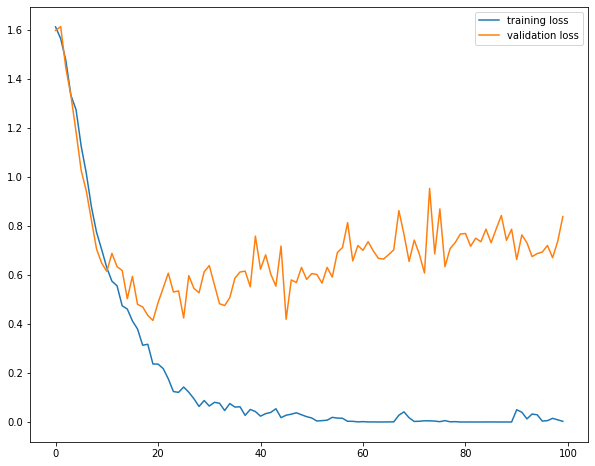

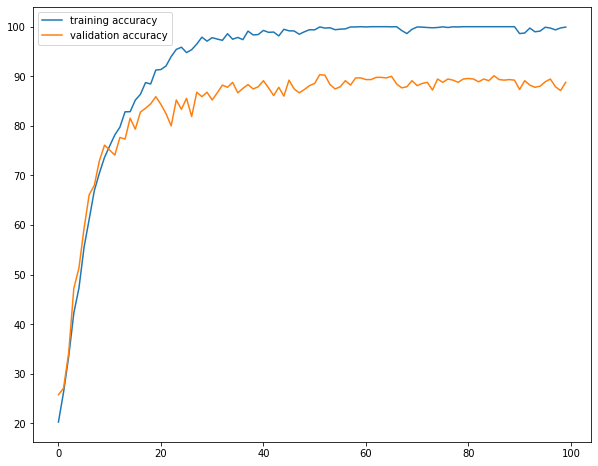

In [15]:
net1, c1, o1 = gen_net()
tl1, vl1, ta1, va1 = training(net1, c1, o1, *cross_val_folds[0])

In [17]:
torch.save(net1.state_dict(), './alex_net_3_f1.pth')

In [18]:
!ls -la

total 285364
drwxr-xr-x 6 root root      4096 Jun  6 17:06 .
drwxr-xr-x 1 root root      4096 Jun  6 15:57 ..
-rw-r--r-- 1 root root 238522543 Jun  6 17:06 alex_net_3_f1.pth
drwxr-xr-x 7 root root      4096 Jun  5 20:42 aug_1
-rw-r--r-- 1 root root  51444576 Jun  6 15:58 aug_1.7z
-rw-r--r-- 1 root root      1543 Jun  6 15:57 dataload.py
drwxr-xr-x 3 root root      4096 Jun  6 16:00 data_process
drwxr-xr-x 2 root root      4096 Jun  6 15:57 dataset
-rw-r--r-- 1 root root      5593 Jun  6 15:57 datatrain.py
-rw-r--r-- 1 root root      2699 Jun  6 15:57 eval.py
drwxr-xr-x 8 root root      4096 Jun  6 15:57 .git
-rw-r--r-- 1 root root        54 Jun  6 15:57 .gitignore
-rw-r--r-- 1 root root      1772 Jun  6 15:57 README.md
-rw-r--r-- 1 root root       121 Jun  6 15:57 requirements.txt
-rw-r--r-- 1 root root   2172207 Jun  6 15:57 show_case_1.ipynb
-rw-r--r-- 1 root root      9590 Jun  6 15:57 show_case_2.ipynb


In [19]:
import numpy as np
np.save('net3_f1_loss_acc', [
  [float(tl.cpu()) for tl in tl1], 
  [float(vl.cpu()) for vl in vl1], 
  [float(ta.cpu()) for ta in ta1], 
  [float(va.cpu()) for va in va1], 
])

# with open('net2_loss_acc.npy', 'rb') as f:
#     a = np.load(f)
#     print(a)

cuda is_available
 90/90 Epoch 1/100, Tr Loss: 1.6146, Tr Acc: 20.5833, Val Loss: 1.5900, Val Acc: 21.6667
 90/90 Epoch 2/100, Tr Loss: 1.5360, Tr Acc: 29.6389, Val Loss: 1.4401, Val Acc: 35.0000
 90/90 Epoch 3/100, Tr Loss: 1.4683, Tr Acc: 34.5556, Val Loss: 1.4094, Val Acc: 40.0000
 90/90 Epoch 4/100, Tr Loss: 1.3264, Tr Acc: 42.8056, Val Loss: 1.3210, Val Acc: 41.3333
 90/90 Epoch 5/100, Tr Loss: 1.2523, Tr Acc: 48.0833, Val Loss: 1.1776, Val Acc: 53.1111
 90/90 Epoch 6/100, Tr Loss: 1.1647, Tr Acc: 53.1667, Val Loss: 1.0078, Val Acc: 58.8889
 90/90 Epoch 7/100, Tr Loss: 1.0447, Tr Acc: 59.6667, Val Loss: 0.8972, Val Acc: 66.7778
 90/90 Epoch 8/100, Tr Loss: 0.9397, Tr Acc: 65.1111, Val Loss: 0.8115, Val Acc: 69.1111
 90/90 Epoch 9/100, Tr Loss: 0.7972, Tr Acc: 70.2222, Val Loss: 0.7257, Val Acc: 72.8889
 90/90 Epoch 10/100, Tr Loss: 0.7436, Tr Acc: 71.8611, Val Loss: 0.9294, Val Acc: 68.1111
 90/90 Epoch 11/100, Tr Loss: 0.6867, Tr Acc: 73.8611, Val Loss: 0.6409, Val Acc: 77.1111
 

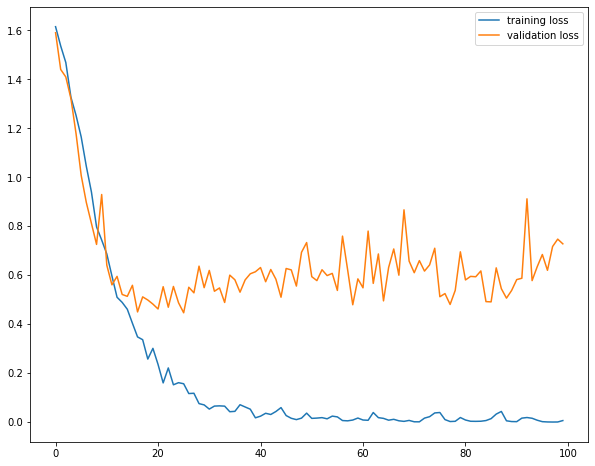

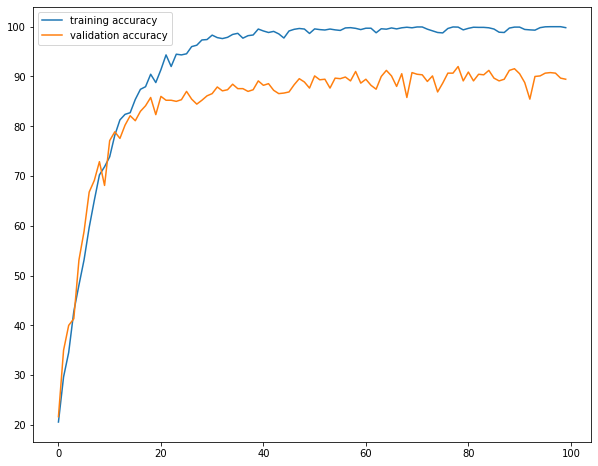

In [20]:
net2, c2, o2 = gen_net()
tl2, vl2, ta2, va2 = training(net2, c2, o2, *cross_val_folds[1])

In [21]:
torch.save(net2.state_dict(), './alex_net_3_f2.pth')
np.save('net3_f2_loss_acc', [
  [float(tl.cpu()) for tl in tl2], 
  [float(vl.cpu()) for vl in vl2], 
  [float(ta.cpu()) for ta in ta2], 
  [float(va.cpu()) for va in va2], 
])

cuda is_available
 90/90 Epoch 1/100, Tr Loss: 1.6112, Tr Acc: 20.1667, Val Loss: 1.5900, Val Acc: 26.0000
 90/90 Epoch 2/100, Tr Loss: 1.5508, Tr Acc: 28.0000, Val Loss: 1.4692, Val Acc: 32.4444
 90/90 Epoch 3/100, Tr Loss: 1.4020, Tr Acc: 39.8889, Val Loss: 1.4185, Val Acc: 40.3333
 90/90 Epoch 4/100, Tr Loss: 1.3020, Tr Acc: 46.1111, Val Loss: 1.2360, Val Acc: 51.4444
 90/90 Epoch 5/100, Tr Loss: 1.1888, Tr Acc: 52.1111, Val Loss: 1.1700, Val Acc: 54.5556
 90/90 Epoch 6/100, Tr Loss: 1.0939, Tr Acc: 56.8889, Val Loss: 1.0202, Val Acc: 62.3333
 90/90 Epoch 7/100, Tr Loss: 0.9714, Tr Acc: 62.1111, Val Loss: 1.0176, Val Acc: 58.6667
 90/90 Epoch 8/100, Tr Loss: 0.8224, Tr Acc: 69.1389, Val Loss: 0.7889, Val Acc: 70.8889
 90/90 Epoch 9/100, Tr Loss: 0.7137, Tr Acc: 73.5000, Val Loss: 0.7366, Val Acc: 74.4445
 90/90 Epoch 10/100, Tr Loss: 0.6216, Tr Acc: 77.3889, Val Loss: 0.7082, Val Acc: 74.6667
 90/90 Epoch 11/100, Tr Loss: 0.5345, Tr Acc: 80.6389, Val Loss: 0.6446, Val Acc: 79.8889
 

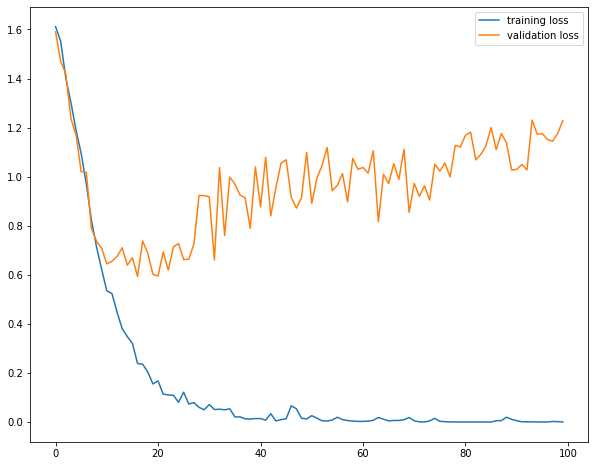

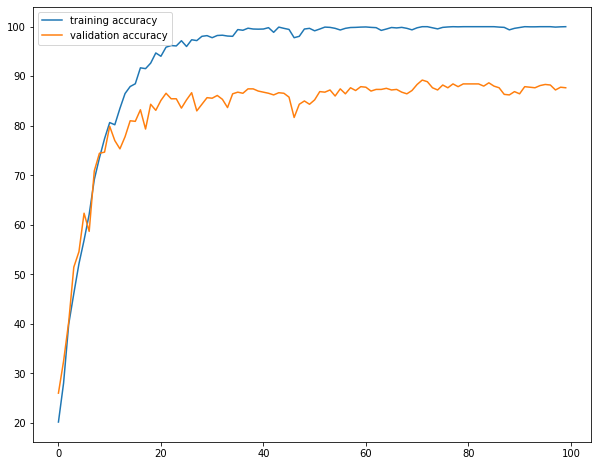

In [22]:
net3, c3, o3 = gen_net()
tl3, vl3, ta3, va3 = training(net3, c3, o3, *cross_val_folds[2])

In [23]:
torch.save(net3.state_dict(), './alex_net_3_f3.pth')
np.save('net3_f3_loss_acc', [
  [float(tl.cpu()) for tl in tl3], 
  [float(vl.cpu()) for vl in vl3], 
  [float(ta.cpu()) for ta in ta3], 
  [float(va.cpu()) for va in va3], 
])

cuda is_available
 90/90 Epoch 1/100, Tr Loss: 1.6100, Tr Acc: 21.3611, Val Loss: 1.5746, Val Acc: 22.7778
 90/90 Epoch 2/100, Tr Loss: 1.5158, Tr Acc: 30.0833, Val Loss: 1.4430, Val Acc: 35.4444
 90/90 Epoch 3/100, Tr Loss: 1.3990, Tr Acc: 37.9444, Val Loss: 1.3184, Val Acc: 44.8889
 90/90 Epoch 4/100, Tr Loss: 1.3121, Tr Acc: 45.1389, Val Loss: 1.2059, Val Acc: 49.6667
 90/90 Epoch 5/100, Tr Loss: 1.1700, Tr Acc: 52.2222, Val Loss: 1.1934, Val Acc: 52.3333
 90/90 Epoch 6/100, Tr Loss: 1.0974, Tr Acc: 57.1111, Val Loss: 0.9982, Val Acc: 62.2222
 90/90 Epoch 7/100, Tr Loss: 0.9291, Tr Acc: 63.6944, Val Loss: 0.9991, Val Acc: 63.3333
 90/90 Epoch 8/100, Tr Loss: 0.8282, Tr Acc: 69.4167, Val Loss: 0.8247, Val Acc: 69.0000
 90/90 Epoch 9/100, Tr Loss: 0.6835, Tr Acc: 74.2778, Val Loss: 0.7806, Val Acc: 70.3333
 90/90 Epoch 10/100, Tr Loss: 0.6599, Tr Acc: 75.8056, Val Loss: 0.6610, Val Acc: 75.6667
 90/90 Epoch 11/100, Tr Loss: 0.5783, Tr Acc: 78.6944, Val Loss: 0.5910, Val Acc: 78.0000
 

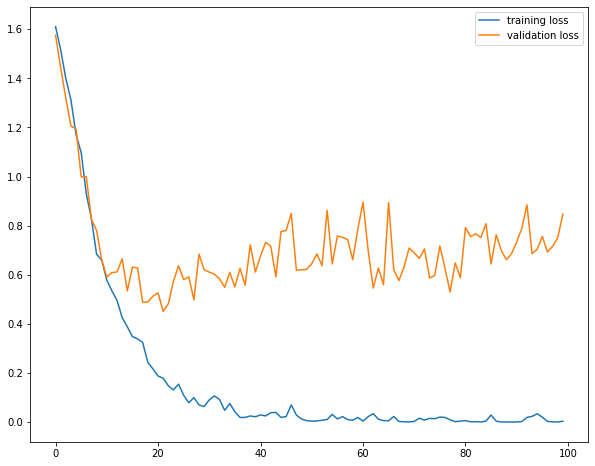

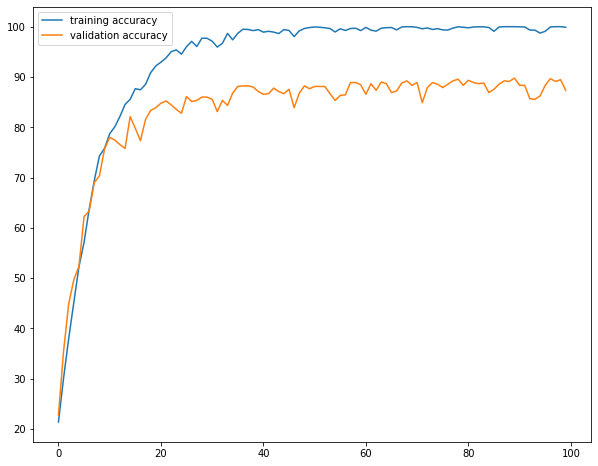

In [24]:
net4, c4, o4 = gen_net()
tl4, vl4, ta4, va4 = training(net4, c4, o4, *cross_val_folds[3])

In [25]:
import numpy as np
torch.save(net4.state_dict(), './alex_net_3_f4.pth')
np.save('net3_f4_loss_acc', [
  [float(tl.cpu()) for tl in tl4], 
  [float(vl.cpu()) for vl in vl4], 
  [float(ta.cpu()) for ta in ta4], 
  [float(va.cpu()) for va in va4], 
])

cuda is_available
 90/90 Epoch 1/100, Tr Loss: 1.6116, Tr Acc: 21.2778, Val Loss: 1.5955, Val Acc: 20.2222
 90/90 Epoch 2/100, Tr Loss: 1.5551, Tr Acc: 27.4444, Val Loss: 1.5202, Val Acc: 31.5556
 90/90 Epoch 3/100, Tr Loss: 1.4288, Tr Acc: 36.9167, Val Loss: 1.2907, Val Acc: 46.6667
 90/90 Epoch 4/100, Tr Loss: 1.3052, Tr Acc: 45.1667, Val Loss: 1.2131, Val Acc: 51.1111
 90/90 Epoch 5/100, Tr Loss: 1.1935, Tr Acc: 51.7500, Val Loss: 1.1679, Val Acc: 53.5556
 90/90 Epoch 6/100, Tr Loss: 1.0861, Tr Acc: 57.6667, Val Loss: 0.9304, Val Acc: 64.3333
 90/90 Epoch 7/100, Tr Loss: 0.9726, Tr Acc: 62.4444, Val Loss: 0.8716, Val Acc: 67.0000
 90/90 Epoch 8/100, Tr Loss: 0.8429, Tr Acc: 68.6389, Val Loss: 0.7743, Val Acc: 72.3333
 90/90 Epoch 9/100, Tr Loss: 0.7531, Tr Acc: 72.4167, Val Loss: 0.7490, Val Acc: 73.6667
 90/90 Epoch 10/100, Tr Loss: 0.7166, Tr Acc: 73.0556, Val Loss: 0.6641, Val Acc: 72.6667
 90/90 Epoch 11/100, Tr Loss: 0.6133, Tr Acc: 76.2778, Val Loss: 0.7029, Val Acc: 73.1111
 

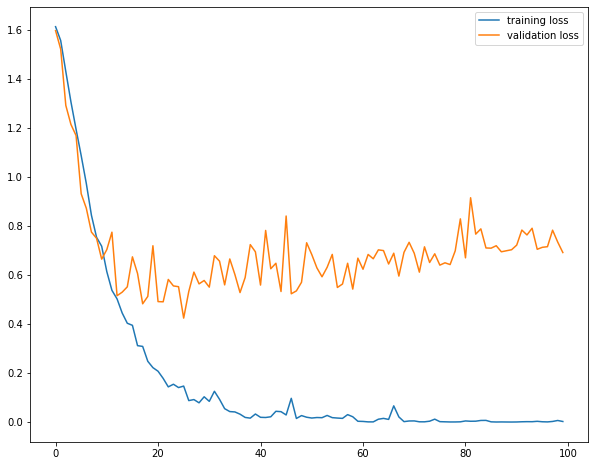

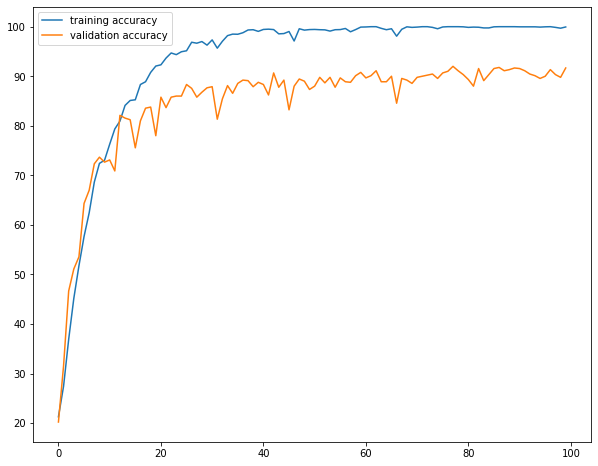

In [26]:
net5, c5, o5 = gen_net()
tl5, vl5, ta5, va5 = training(net5, c5, o5, *cross_val_folds[4])

In [27]:
import numpy as np
torch.save(net5.state_dict(), './alex_net_3_f5.pth')
np.save('net3_f5_loss_acc', [
  [float(tl.cpu()) for tl in tl5], 
  [float(vl.cpu()) for vl in vl5], 
  [float(ta.cpu()) for ta in ta5], 
  [float(va.cpu()) for va in va5], 
])